## Testing notebook for fitting the model of _Brunton et. al. (2013)_

In [1]:
using Distributed

In [2]:
# add additional processors
addprocs(44);

In [3]:
using pulse_input_DDM

┌ Info: Recompiling stale cache file /usr/people/briandd/.julia/compiled/v1.0/pulse_input_DDM/m8WoA.ji for pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1190


## Recover generative parameters

Simulate clicks and choices from a model, then check that generative parameters can be recovered.

In [4]:
#parameters of the latent model
pz = Dict("generative" => vcat(1.,13.,-0.5,10.,1.,0.4,0.02), 
    "name" => vcat("σ_i","B", "λ", "σ_a","σ_s","ϕ","τ_ϕ"),
    "fit" => vcat(trues(7)),
    "initial" => vcat(2.,15.,-5.,100.,2.,0.2,0.005),
    "lb" => [eps(), 4., -5., eps(), eps(), eps(), eps()],
    "ub" => [10., 100, 5., 800., 40., 2., 10.])

#parameters for the choice observation
pd = Dict("generative" => vcat(0.1,0.1), 
    "name" => vcat("bias","lapse"), "fit" => trues(2), 
    "initial" => vcat(0.,0.5));

In [5]:
#generate a synthetic data set of clicks and choices
ntrials = Int(2e4)
data = sample_inputs_and_choices(pz["generative"], pd["generative"], ntrials);

In [7]:
#bin the click inputs at 10 ms
data = bin_clicks!(data;dt=1e-2);

In [7]:
#compute the likelihood of the data, given the generative parameters
compute_LL(pz["generative"], pd["generative"], data)

-7668.67051720735

In [8]:
#find the ML parameters with gradient descent
@time pz, pd, = optimize_model(pz, pd, data);

┌ Warning: some parameter(s) at lower bound. bumped it (them) up 1/4 from the lower bound.
└ @ pulse_input_DDM /usr/people/briandd/.julia/packages/pulse_input_DDM/edA5O/src/wrapper_functions.jl:60


Iter     Function value   Gradient norm 
     0     9.712882e+03     3.170461e+03
     1     7.851626e+03     4.480611e+02
     2     7.774975e+03     3.503178e+02
     3     7.747243e+03     1.998314e+02
     4     7.718867e+03     3.252924e+02
     5     7.712212e+03     3.489658e+02
     6     7.709746e+03     3.378718e+02
     7     7.688951e+03     1.902644e+02
     8     7.687867e+03     1.679258e+02
     9     7.686370e+03     7.666025e+01
    10     7.674276e+03     2.299531e+01
    11     7.673091e+03     8.676301e+00
    12     7.672506e+03     8.919701e+00
    13     7.671471e+03     2.840980e+01
    14     7.670712e+03     2.978501e+01
    15     7.668184e+03     2.857098e+01
    16     7.668033e+03     2.885896e+01
    17     7.666791e+03     1.706681e+01
    18     7.666681e+03     6.245323e+00
    19     7.666430e+03     1.283727e+01
    20     7.666360e+03     9.933007e+00
    21     7.666144e+03     2.557841e+00
    22     7.666096e+03     3.105341e+00
    23     7.666

In [9]:
#compute the Hessian of the LL landscape, to compute confidence intervals on the parameters
pz, pd = compute_H_CI!(pz, pd, data);

In [10]:
using DataFrames
show(DataFrame(pz),allcols=true)
show(DataFrame(pd),allcols=true)

7×11 DataFrame
│ Row │ CI_minus    │ CI_plus   │ final     │ fit  │ generative │ initial │
│     │ Float64     │ Float64   │ Float64   │ Bool │ Float64    │ Float64 │
├─────┼─────────────┼───────────┼───────────┼──────┼────────────┼─────────┤
│ 1   │ 0.000242663 │ 4476.62   │ 1.04226   │ true │ 1.0        │ 2.0     │
│ 2   │ 6.57436     │ 17.1239   │ 9.81253   │ true │ 13.0       │ 15.0    │
│ 3   │ -1.13079    │ 0.157419  │ -0.494979 │ true │ -0.5       │ -5.0    │
│ 4   │ 0.0128488   │ 860.236   │ 3.32461   │ true │ 10.0       │ 100.0   │
│ 5   │ 0.592886    │ 2.10235   │ 1.11645   │ true │ 1.0        │ 2.0     │
│ 6   │ 0.19959     │ 0.5797    │ 0.34015   │ true │ 0.4        │ 0.2     │
│ 7   │ 0.0107615   │ 0.0276737 │ 0.0172572 │ true │ 0.02       │ 0.005   │

│ Row │ lb          │ name   │ state     │ ub      │ within_CI │
│     │ Float64     │ String │ Float64   │ Float64 │ Bool      │
├─────┼─────────────┼────────┼───────────┼─────────┼───────────┤
│ 1   │ 2.22045e-16 │ σ_i    

In [11]:
#simulate choices from the model, given the ML parameters
ML_data = deepcopy(data)
sample_choices_all_trials!(ML_data, pz["final"], pd["final"])

#compute the final click difference, which will dictate the correct choice
ΔLR = map((nT,L,R)->diffLR(nT,L,R,data["dt"])[end], data["nT"], data["leftbups"], data["rightbups"]);

In [12]:
#bin the choices from the generative parameters and from the ML parameters
import Pandas: qcut
import Statistics: mean

nbins = 15;
conds,qcut_bins = qcut(ΔLR, nbins, labels=false, retbins=true);
conds = conds .+ 1;

frac_choice_ML = [mean(ML_data["pokedR"][conds .== i]) for i in 1:nbins]
frac_choice_gen = [mean(data["pokedR"][conds .== i]) for i in 1:nbins];

In [13]:
#fit a GLM to the generative choices and the ML choices
using GLM
GLM_gen = glm(@formula(Y ~ X), DataFrame(X=ΔLR, Y = data["pokedR"]), Binomial(), LogitLink())
GLM_ML = glm(@formula(Y ~ X), DataFrame(X=ΔLR, Y = ML_data["pokedR"]), Binomial(), LogitLink());

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[14]:14
└ @ Core In[14]:14
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[14]:14
└ @ Core In[14]:14


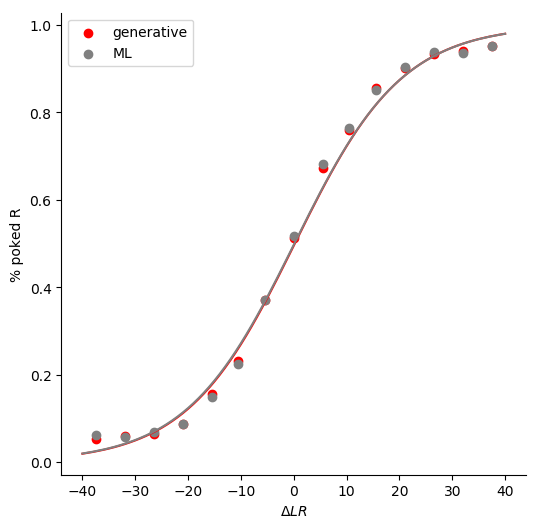

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[14]:15
└ @ Core In[14]:15
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[14]:15
└ @ Core In[14]:15


PyObject <matplotlib.legend.Legend object at 0x7fb6fb215320>

In [14]:
using PyPlot

fig = figure(figsize=(6,6))
ax = subplot(111)

scatter(qcut_bins[1:end-1] + diff(qcut_bins)/2, frac_choice_gen, color="red", label="generative")
scatter(qcut_bins[1:end-1] + diff(qcut_bins)/2, frac_choice_ML, color="grey", label="ML")

plot(sort(ΔLR), sort(predict(GLM_gen)), color="red")
plot(sort(ΔLR), sort(predict(GLM_ML)), color="grey")

ylabel("% poked R")
xlabel(L"\Delta{LR}")
ax[:spines]["top"][:set_color]("none") 
ax[:spines]["right"][:set_color]("none")
legend()

## fit real data

In [ ]:
# to fit real data, see Documentation for the expected structure of .mat files. Group animals into a 1D array
# Sessions for each animal are 1D arrays, and they are grouped into a 1D array (i.e. an array of arrays)

In [15]:
path = "/path/to/mat/files"
ratnames=["P055"] 
sessids=[[17061800,18041700,16052600,16070500,16111700,18010300,18022600,17122200,
        17081200,17092600,17051900,18030500,17011800,18012200,17011500,17062500,
        17112700,18032700,16082200,18060800,18032500,17082900,17080500,17081000,
        17052300,17090800,17090900,18041500,18040500,17122000]];

In [69]:
@eval $(Symbol("pz_$ratnames[1]")), $(Symbol("pz_$ratnames[1]")) = load_and_optimize(path, sessids, ratnames; dt=1e-2)

Iter     Function value   Gradient norm 
     0     5.198612e+03     1.179490e+03
     1     5.062700e+03     7.092697e+02
     2     4.866877e+03     1.073818e+02
     3     4.862412e+03     8.480257e+01
     4     4.854455e+03     7.851770e+01
     5     4.843588e+03     2.548006e+01
     6     4.842185e+03     2.133754e+01
     7     4.839475e+03     4.747778e+01
     8     4.834006e+03     5.577361e+01
     9     4.828484e+03     5.779659e+01
    10     4.824905e+03     5.678582e+01
    11     4.816160e+03     6.422642e+01
    12     4.794884e+03     4.350633e+01
    13     4.794010e+03     5.807570e+01
    14     4.789842e+03     5.181033e+01
    15     4.788941e+03     3.346028e+01
    16     4.785648e+03     6.769594e+01
    17     4.782202e+03     4.453928e+01
    18     4.778949e+03     1.973984e+01
    19     4.776610e+03     1.268894e+01
    20     4.774120e+03     2.688848e+01
    21     4.772299e+03     4.290694e+01
    22     4.771867e+03     2.537150e+01
    23     4.771

(Dict{String,AbstractArray{T,1} where T}("name"=>["σ_i", "B", "λ", "σ_a", "σ_s", "ϕ", "τ_ϕ"],"lb"=>[2.22045e-16, 4.0, -5.0, 2.22045e-16, 2.22045e-16, 2.22045e-16, 2.22045e-16],"ub"=>[10.0, 100.0, 5.0, 800.0, 40.0, 2.0, 10.0],"fit"=>Bool[true, true, true, true, true, true, true],"initial"=>[1.0e-6, 20.0, -0.1, 100.0, 5.0, 0.2, 0.005],"final"=>[1.00771e-6, 4.00235, -4.99875, 0.000265405, 2.19336, 0.000150821, 0.0147532],"state"=>[1.00771e-6, 4.00235, -4.99875, 0.000265405, 2.19336, 0.000150821, 0.0147532]), Dict{String,AbstractArray{T,1} where T}("name"=>["bias", "lapse"],"fit"=>Bool[true, true],"initial"=>[0.0, 0.5],"final"=>[-0.702246, 0.233489],"state"=>[-0.702246, 0.233489]))

## saving things

In [ ]:
using JLD2
JLD2.@save "path/file.jld" pz pd